# Comparing Trends in Surface Concavity and Inner Velocity of Ice Rise Model
### RCES Final Project
Janette Levin

### Background information: 

Ice rises are elevated masses of ice, usually dome shaped, that rise above the surrounding ice sheet. Ice rises play a large role in grounding and buttressing the ice shelf, so understanding their evolution is critical to predicting how the ice shelf will behave in the future. 
Ice rises have an unexplained assymetry - see image below of Korff Ice Rise, with both GPS and Satellite data.

![data_sample](rema_vs_gps_korff.png)

### Question: Are trends in surface concavity reflected in the inner velocity field?

#### Data: Model output from simulated ice rise run using Elmer/Ice - Finite Element Full Stokes model.

Data is currently stored in GCS.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import xarray as xr
import gcsfs

## Generate NetCDF file from vtu files stores in GCS

Current netcdf stored on GCS

In [2]:
#%run ./netcdf_from_vtu.ipynb   #toil
#datacomb = vtu_transform()

fs = gcsfs.GCSFileSystem(project='ldeo-glaciology')
fullrun = fs.open('ldeo-glaciology/elmer_janie/netcdf_files/full_run.nc')
datacomb = xr.open_dataset(fullrun)

### Creates xarray with dimensions in x,y,t.

This is an unstructured grid so the logical dimensions (x,y) also need to be used to find the xvalues and yvalues of the gridpoints - the coordinates xvals and yvals.

Each t is a 10 year time step, which we assign to the 'years' coordinate 

In [3]:
datacomb = datacomb.assign_coords(years = (datacomb.t * 10))
datacomb

<xarray.Dataset>
Dimensions:  (t: 120, xnode: 1001, ynode: 31)
Coordinates:
    yvals    (t, ynode, xnode) float64 ...
    xvals    (t, ynode, xnode) float64 ...
    years    (t) int64 0 10 20 30 40 50 60 ... 1140 1150 1160 1170 1180 1190
Dimensions without coordinates: t, xnode, ynode
Data variables:
    vel_x    (t, ynode, xnode) float64 ...
    vel_y    (t, ynode, xnode) float64 ...

### Question 1: How does the surface of this ice model evolve?

The surface is a 1D line. In the model we change parameters of accumulation and flux, affecting the way the surace profile behaves. Here, the surface evolution is shown at 100 year intervals, as it evolves from a flat sheet into a dome. 



Text(0, 0.5, 'yvals (m)')

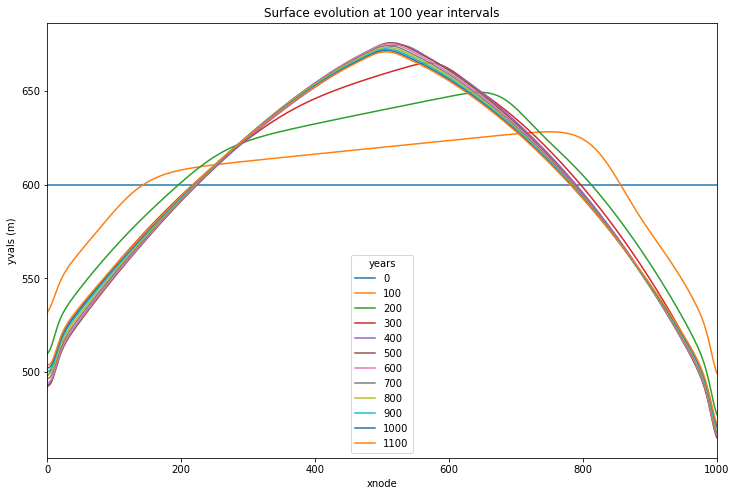

In [4]:
plt.figure(figsize = [12,8])

datacomb.sel(t= np.arange(0,120,10),ynode = (datacomb.ynode.shape[0] - 1)).yvals.plot(hue='years');
plt.xlim([0,1000])
plt.title('Surface evolution at 100 year intervals')
plt.ylabel('yvals (m)')

### First, we need to analyze the surface numerically:

I am using finite differences to calculate 1st and 2nd derivatives of each surface profile. The full command is in the function file netcdf_from_vtu, but results have been pre-processed and stored on the GCS for demonstration purposes.

In [5]:
#surfder = surface_deriv(datacomb)

In [6]:
surfrun = fs.open('ldeo-glaciology/elmer_janie/netcdf_files/surfder.nc')
surfder = xr.open_dataset(surfrun)

### Example Analysis of One Time Slice

We are interested in the behaviour around the peak so we cut off the boundary effects and pick an arbitrary time slice to test the analysis on one time slice.

In [7]:
surf_narrow = surfder.sel(xnode = slice(400,601))
singleslice = surf_narrow.sel(t = 40)
singleslice

<xarray.Dataset>
Dimensions:  (xnode: 201)
Coordinates:
    xvals    (xnode) float64 ...
    years    int64 ...
Dimensions without coordinates: xnode
Data variables:
    yvals    (xnode) float64 ...
    dy       (xnode) float64 ...
    dy2      (xnode) float64 ...

The following calculates the peak value (where 1st derivative crosses the x axis), inflection points (where 2nd derivative crosses the x axis), and points of maximum concavity on either side of the peak. All of these points will be used to quantify changes to the concavity of the surface profile.

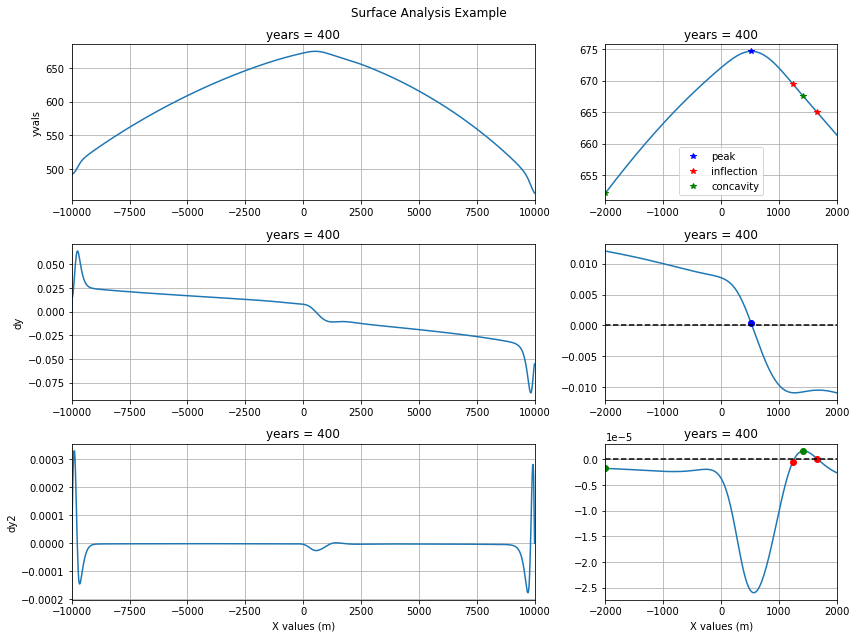

In [8]:

peakind = 0
inflind = []
L = singleslice.dy2.shape[0]

#inflection points and peak
for i in range(L-1):
    if singleslice.dy[i]*singleslice.dy[i+1] < 0:
        peakind = i
    if singleslice.dy2[i]*singleslice.dy2[i+1] < 0:
        inflind.append(i)
#maximum concavity
c_l = singleslice.dy2[0:peakind].argmax()
c_r = singleslice.dy2[peakind:].argmax() + peakind

fig, ax = plt.subplots(ncols = 2,nrows = 3, figsize = [12,9],gridspec_kw={'width_ratios': [2, 1]})
surfder.yvals.sel(t = 40).plot(ax = ax[0,0],x = 'xvals')
surfder.dy.sel(t = 40).plot(ax = ax[1,0],x = 'xvals')
surfder.dy2.sel(t = 40).plot(ax = ax[2,0],x = 'xvals')
for x in range(3):
    ax[x,0].set_xlim([-10000,10000])
    ax[x,0].set_xlabel('')
    ax[x,0].grid()
#ax[0,0].set_title('Surface Analysis Example')
ax[2,0].set_xlabel('X values (m)')

singleslice.yvals.plot(ax = ax[0,1],x= 'xvals')
ax[0,1].plot(singleslice.xvals[peakind],singleslice.yvals[peakind], 'b*',label = 'peak')
ax[0,1].plot(singleslice.xvals[inflind],singleslice.yvals[inflind], 'r*', label = 'inflection')
ax[0,1].plot(singleslice.xvals[[c_l,c_r]],singleslice.yvals[[c_l,c_r]], 'g*', label = 'concavity')

singleslice.dy.plot(ax = ax[1,1],x= 'xvals')
ax[1,1].plot(singleslice.xvals[peakind],singleslice.dy[peakind], 'bo')
ax[1,1].plot([-2000,2000],[0,0], 'k--')

singleslice.dy2.plot(ax = ax[2,1],x= 'xvals')
ax[2,1].plot(singleslice.xvals[inflind],singleslice.dy2[inflind], 'ro')
ax[2,1].plot(singleslice.xvals[[c_l,c_r]],singleslice.dy2[[c_l,c_r]], 'go')
ax[2,1].plot([-2000,2000],[0,0], 'k--')

for x in range(3):
    ax[x,1].set_xlim([-2000,2000])
    ax[x,1].set_xlabel('')
    ax[x,1].set_ylabel('')
    
    ax[x,1].grid()
ax[2,1].set_xlabel('X values (m)')
ax[0,1].legend(loc = 'lower center')
fig.suptitle('Surface Analysis Example')
plt.tight_layout()

## Repeat Same analysis for all time steps
In order to get an idea of how the surface bheaves over time, we plot the points of interest for each time step.
(This takes a minute or two so I have also pre-processed them and stored them on GCS. Uncomment below to run the command itself. 

In [9]:
#peakdat,concdat,inflind = surf_analyze(surfder.sel(xnode = slice(100,901)),10)

These commands open pre-processed netcdf files from GCS

In [10]:
peakrun = fs.open('ldeo-glaciology/elmer_janie/netcdf_files/peak_vals.nc')
peakdat = xr.open_dataset(peakrun)

inflrun = fs.open('ldeo-glaciology/elmer_janie/netcdf_files/infl_vals.nc')
infldat = xr.open_dataset(inflrun)

concrun = fs.open('ldeo-glaciology/elmer_janie/netcdf_files/conc_vals.nc')
concdat = xr.open_dataset(concrun)

Text(0, 0.5, 'X values (m)')

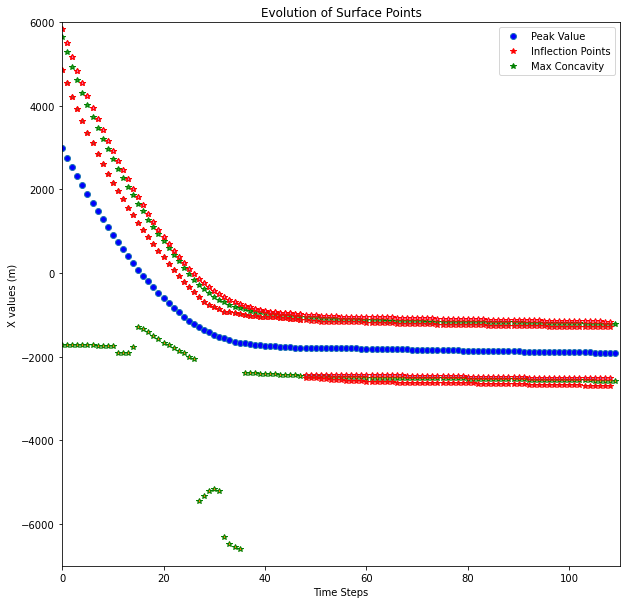

In [11]:
fig,ax = plt.subplots(figsize = [10,10])
peakdat.sel(ynode = (peakdat.ynode.shape[0] - 1)).xvals.plot(marker = 'o', markerfacecolor = 'blue', linestyle='None', ax = ax, label ='Peak Value')

gsc = concdat.sel(ynode = (concdat.ynode.shape[0] - 1)).groupby('xnode')

for gname, gp in gsc:
    gp.xvals.plot(marker = '*',linestyle='None',markeredgecolor = 'green', ax = ax)

gsi = infldat.sel(ynode = (concdat.ynode.shape[0] - 1)).groupby('xnode')
for gname, gp in gsi:
    gp.xvals.plot(marker = '*',linestyle='None',markeredgecolor = 'red', ax = ax)


plt.plot(150,0,'r*',label = 'Inflection Points')
plt.plot(150,0,'g*',label = 'Max Concavity')
plt.title('Evolution of Surface Points')
plt.ylim([-7000,6000])
plt.xlim([0,110])
plt.legend(loc = 'upper right')
plt.xlabel('Time Steps')
plt.ylabel('X values (m)')

This graph shows that while the ice rise is forming, there are inflection points on one side, but the second side only develops them after the ice rise reaches a fairly steady state. 

### Question 2: What is happening to the internal velocity over time ?

Once again, we slice off the boundary values, since they have larger velocities that throw off the scaling of the region of interest in the center.

In [12]:
data_nb = datacomb.sel(xnode = slice(200,801))
data_nb

<xarray.Dataset>
Dimensions:  (t: 120, xnode: 601, ynode: 31)
Coordinates:
    yvals    (t, ynode, xnode) float64 ...
    xvals    (t, ynode, xnode) float64 ...
    years    (t) int64 0 10 20 30 40 50 60 ... 1140 1150 1160 1170 1180 1190
Dimensions without coordinates: t, xnode, ynode
Data variables:
    vel_x    (t, ynode, xnode) float64 ...
    vel_y    (t, ynode, xnode) float64 ...

### Horizontal Velocity

We plot the horizontal velocity inside the ice rise at various time steps. It evolves as expected for the unequal accumulation this model has. Early time steps have somewhat erratic behaviour due to the evolution of the slab into a dome.

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/plot/facetgrid.py:421: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  self._mappables[-1], ax=list(self.axes.flat), **kwargs


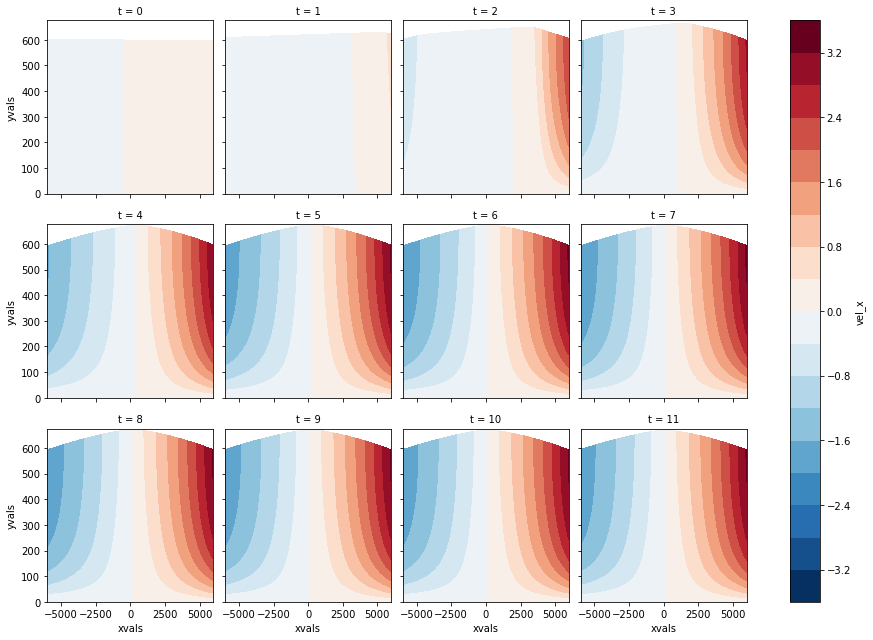

In [13]:
data_nb.sel(t = np.arange(0,120,10)).vel_x.plot.contourf(x = 'xvals', y = 'yvals',
    col = 't', col_wrap = 4, levels = 20
)

#### Vertical Velocity
Vertical velocity shows interesting transitions between time step 4 and 5, where velocity contours left of the peak go from being parallel to the surface to intersecting the surface. Again, however, it is unclear whether this is a result of the evolution from a flat slab, or an effect of accumulation-induced ice migration.

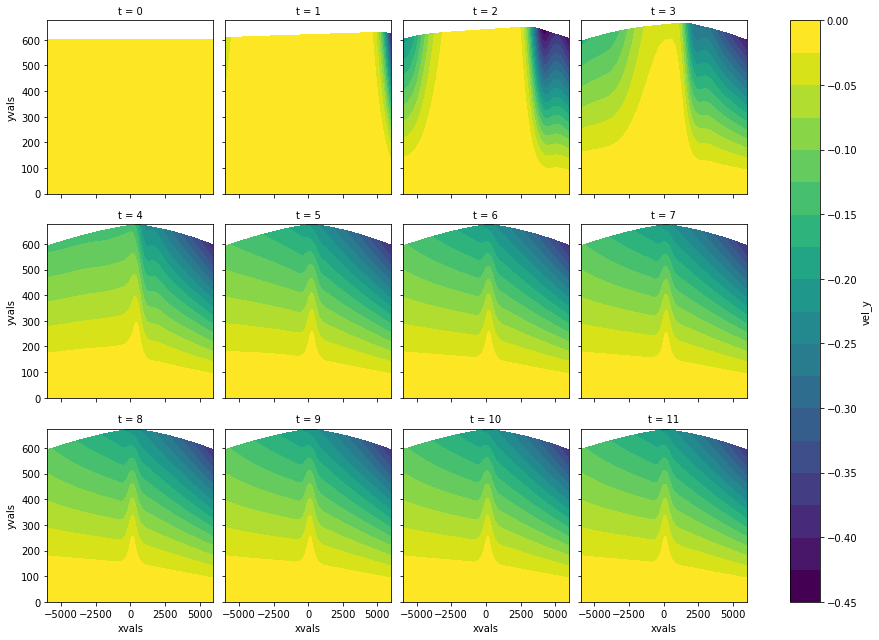

In [14]:

data_nb.sel(t = np.arange(0,120,10)).vel_y.plot.contourf(x = 'xvals', y = 'yvals',
    col = 't', col_wrap = 4, levels = 20
)

### Velocity profiles at Inflection Points

The behaviour of velocities at inflection points on either side of the peak are plotted here. "Right" points are present from the beginning, and have evolving velocity profiles, while "left" points evolve only after the ice rise reaches a fairly steady state, and have consistent velocity profiles.

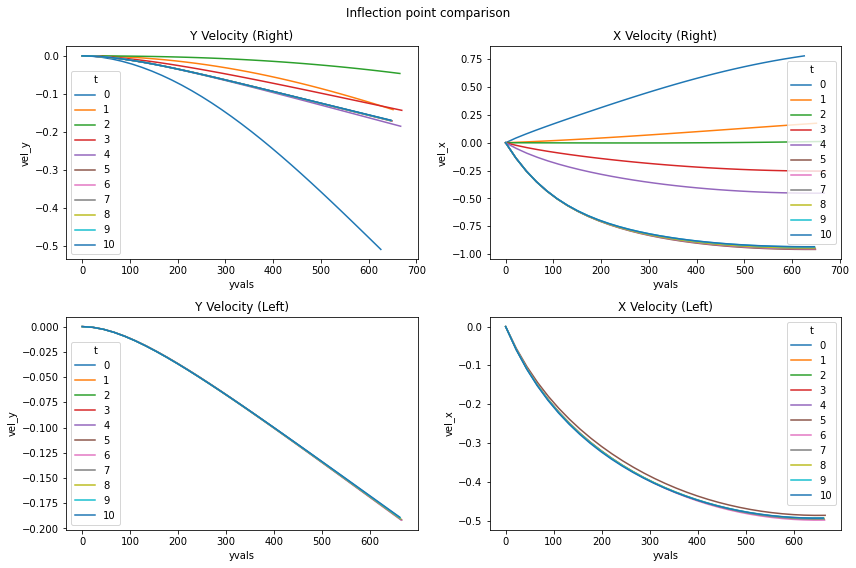

In [15]:
fig,ax = plt.subplots(figsize = [12,8], ncols = 2, nrows = 2)
infldat.sel(t = np.arange(0,110,10),xnode = 1).vel_y.plot(x = 'yvals', hue = 't', ax = ax[0,0])

infldat.sel(t = np.arange(0,110,10),xnode = 1).vel_x.plot(x = 'yvals', hue = 't', ax = ax[0,1])

infldat.sel(t = np.arange(0,110,10),xnode = 3).vel_y.plot(x = 'yvals', hue = 't', ax = ax[1,0])

infldat.sel(t = np.arange(0,110,10),xnode = 3).vel_x.plot(x = 'yvals', hue = 't', ax = ax[1,1])
ax[0,0].set_title('Y Velocity (Right)')
ax[0,1].set_title('X Velocity (Right)')

ax[1,0].set_title('Y Velocity (Left)')
ax[1,1].set_title('X Velocity (Left)')
fig.suptitle('Inflection point comparison')
plt.tight_layout()

### Conclusion

The model run here featured the evolution of an ice rise from a flat slab using an uneven acccumulation. The evolution of the dome from a flat slab interferes with making clear connections between accumulation and velocity effects. The next run will be run starting from a steady state ice rise, with varying accumulation, to constrain the ice rise migration better.
This project has also allowed for a powerful way to visualize the model output and compare it acc. 